In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA   # 白化

# 用tensorboard来可视化模型
from tensorboardX import SummaryWriter  # writer就相当于一个日志，保存你要做图的所有信息

In [2]:
# 设置随机数种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(20)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Hyper-parameters for updating learning rate
num_epochs = 75
learning_rate = 0.01
batch_size = 128
is_whitened = True

# lr updating parameters
epochs = [1, 3, 4, 30, 31, 50, 51, 70, 71, num_epochs]
lrs = [learning_rate, 0.2, 0.1, 0.1, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001]

In [4]:
# 数据增强方法：1.cutout
class Cutout(object):
    """Randomly mask out one or more patches（补丁，就是一个遮挡小块） from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            # (x,y)表示方形补丁的中心位置
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
# 2.Padding + RandomCrop,用transform自带函数做增强
# 3.mixup也是一种简单的数据增强方法,应用地方是在训练的时候，详见 https://blog.csdn.net/winycg/article/details/88410981
#   beta分布参见 https://www.cnblogs.com/think-and-do/p/6593809.html
# 4.label_smoothing 标签平滑是提高分类问题中神经网络训练速度和泛化的一个成熟技巧。
# 在Inception论文中提出，对标签label进行增强，作者认为one-hot编码会过拟合，因此作者在交叉熵中对错误label也分配了很小的权重来防止过拟合。
# 作者引入了参数ϵ, 详见 https://blog.csdn.net/winycg/article/details/88410981
# 在label_smoothing之后，loss的数值可能会增大一些，这与acuracy无关
def CrossEntropyLoss_label_smooth(outputs, targets, device,       # outputs (bs,10)   targets(bs,)
                                  num_classes=10, epsilon=0.075):
    N = targets.size(0)
    smoothed_labels = torch.full(size=(N, num_classes),
                                 fill_value=epsilon / (num_classes - 1))
    smoothed_labels.scatter_(dim=1, index=torch.unsqueeze(targets.to('cpu'), dim=1),  # torch.unsqueeze(..,dim=1),在维度1处，扩展维度
                             value=1-epsilon) 
                                          # dim=1表示以行(第一维度)为单位，要填充的数为value，填充的位置为index，这里index维度（bs,1）
                                          # 在smoothed_labels(维度(bs，10))上面扩充，对应的位置用1-epsilon覆盖之前的epsilon/9...
    smoothed_labels = smoothed_labels.to(device)
    log_prob = nn.functional.log_softmax(outputs, dim=1)   # (bs,)
    loss = - torch.sum(log_prob * smoothed_labels) / N
    return loss

# 5 白化 可以提前对数据处理，然后保存数据
def whiten(imgs,epsilon=1e-1):                             # imgs:(N,H,W,C),int数据类型
    N,H,W,C = imgs.shape
    imgs_flatten = imgs.reshape(N,-1)                     # imgs_flatten(N,H,W,C)
    
    imgs_norm = imgs_flatten/255.
    imgs_norm = imgs_norm - imgs_norm.mean(axis=0)        # axis=0表示对每一列求平均值
    cov = np.cov(imgs_norm, rowvar=True)                  # rowvar=True by default
    U,S,V = np.linalg.svd(cov)
    imgs_ZCA = U.dot(np.diag(1.0/np.sqrt(S + epsilon))).dot(U.T).dot(imgs_norm)
    imgs_ZCA_rescaled = (imgs_ZCA - imgs_ZCA.min()) / (imgs_ZCA.max() - imgs_ZCA.min())

    imgs_whitened = imgs_ZCA_rescaled.reshape(N,H,W,C)
    imgs_whitened = (imgs_whitened * 255).astype(int)
    return imgs_whitened

In [5]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data',train=True, download=False)

# 不想让val_dataset有各种各样的transforms
#val_dataset.transforms = transforms.Compose([transforms.ToTensor(),
#                                             transforms.Normalize(cifar_norm_mean, cifar_norm_std)])                                  

test_dataset = torchvision.datasets.CIFAR10(root='./data',train=False, download=False)

# 保存array形式数据
train_data = train_dataset.data
train_targets = np.array(train_dataset.targets)
test_data = test_dataset.data
test_targets = np.array(test_dataset.targets)

# 对数据做PCA白化,要分开做，不然一次不能分配50000*50000的矩阵那么大的空间
train_data_whitened = np.zeros(train_data.shape,dtype = int)
test_data_whitened = np.zeros(test_data.shape,dtype = int)

# epsilon 和 image batch number，whitening的效果将会由这两个超参数决定。epsilon 越低，batch number越大，白化效果越严重
if is_whitened:
    for i in range(50):
        train_data_whitened[i*1000:(i+1)*1000] = whiten(train_data[i*1000:(i+1)*1000],epsilon=1)
    for i in range(10):
        test_data_whitened[i*1000:(i+1)*1000] = whiten(test_data[i*1000:(i+1)*1000],epsilon=1)
else:
    train_data_whitened = train_data
    test_data_whitened = test_data

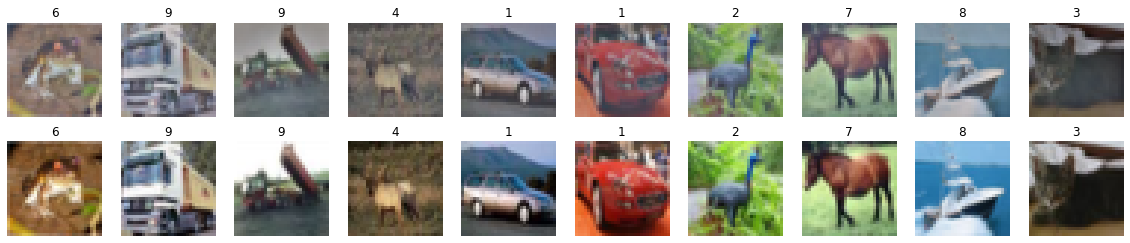

In [6]:
# 查看白化效果
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    if i < 10 :
        plt.imshow(train_data_whitened[i])
        plt.title('{}'.format(train_targets[i]))
        plt.axis('off')
    else:
        plt.imshow(train_data[i-10])
        plt.title('{}'.format(train_targets[i-10]))
        plt.axis('off')
plt.show()        

# 设置成channel first，之前直接读取torchvision.datasets.CIFAR10，会自动变成channel first，
# 但是转换成numpy时候，又会自动变成channel last，因为numpy就是这么约定俗成的，因此这里要自己设置channel first为后面做准备
train_data_whitened = np.transpose(train_data_whitened, (0, 3, 1, 2))
test_data_whitened = np.transpose(test_data_whitened, (0, 3, 1, 2))

# 变成tensor
train_data_whitened = torch.from_numpy(train_data_whitened).type(torch.float32)
train_targets = torch.from_numpy(train_targets).type(torch.int64)
test_data_whitened = torch.from_numpy(test_data_whitened).type(torch.float32)
test_targets = torch.from_numpy(test_targets).type(torch.int64)

In [7]:
# transformations
cifar_norm_mean = (0.49139968, 0.48215827, 0.44653124)
cifar_norm_std = (0.24703233, 0.24348505, 0.26158768)
train_transforms = transforms.Compose([
                                    transforms.Pad(4),     #图像长宽周围都填充4个单位长度（像素）,（32，32）->（40，40）
                                    transforms.RandomCrop(32),         #随机切割，切割完后的尺寸为32*32
                                    transforms.RandomHorizontalFlip(),  #对PIL.image水平翻转，默认反转概率0.5
                                    transforms.ToTensor(),  # totensor要放在这个固定的位置，之前是image，之后是normalize
                                    transforms.Normalize(cifar_norm_mean, cifar_norm_std),
                                    Cutout(n_holes=1, length=16)])
test_transforms = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(cifar_norm_mean, cifar_norm_std)])  

# Dataset
# 注意，这里的TensorDataset与之前的dataset方法不太一样
# 比如，要查看train_dataset的第一个数据，直接看train_dataset[0]，其第1个train_X为train_dataset[0][0],第1个train_y为train_dataset[0][1]
# 没有data和targets函数接口
train_dataset = torch.utils.data.TensorDataset(train_data_whitened,train_targets)
train_dataset.transforms = train_transforms
train_dataset_sub, val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000]) #train_dataset, val_dataset是subset

test_dataset = torch.utils.data.TensorDataset(test_data_whitened,test_targets)
test_dataset.transforms = test_transforms

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_sub,
                                           batch_size=batch_size,    # 设置成2的幂性能优化,因为线程数通常是2^n这种数字
                                           shuffle=True,
                                           #num_workers=2,
                                           pin_memory=(torch.cuda.is_available()),
                                           )

val_loader = test_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          #num_workers=2,
                                          pin_memory=(torch.cuda.is_available()),
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          #num_workers=2,
                                          pin_memory=(torch.cuda.is_available()),
                                          )

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.CELU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
        self.celu = nn.CELU(inplace=True)

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = self.celu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.CELU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)
        self.avg_pool = nn.AvgPool2d(4)
        
        # 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)        # (64,32,32)
        out = self.layer1(out)     # (64,32,32)
        out = self.layer2(out)     # (128,16,16)
        out = self.layer3(out)     # (256,8,8)
        out = self.layer4(out)     # (512,4,4)
        out = self.avg_pool(out)   # (512,1,1)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = ResNet18(ResidualBlock).to(device)

In [9]:
# 保存模型结构
dummy_input = torch.rand(20, 3, 32, 32).to(device)  # 假设输入20张3*32*32的图片
with SummaryWriter(comment='Resnet18') as w:
    w.add_graph(model, (dummy_input,))
    
print('# model parameters:', sum(param.numel() for param in model.parameters()))
    
# 如果要看模型，需要：
# 1.在你的terminal（终端）中 ，在D:\我的代码\jupyter notebook\Programs\CIFAR10\runs 地址下，使用以下命令
# tensorboard --logdir Nov20_21-13-56_LAPTOP-F48B5MHEResnet9
# 2.在浏览器输入
# http://localhost:6006

# model parameters: 11173962


In [10]:
# prediction function for simple data
def pred_rate(preds,labels):
    return preds.eq(labels).sum().item()/labels.shape[0]

# prediction function for data loader
def pred_rate_loader(model, val_loader, device):
    model.eval()
    
    with torch.no_grad():         # 使用 torch,no_grad()构建不需要track的上下文环境，这个时候再不会跟踪track各个tensor的梯度
        correct = 0
        total = 0
        loss = []
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            loss.append(CrossEntropyLoss_label_smooth(outputs, labels, device).cpu().numpy())
            
    model.train()
    return np.mean(loss), correct / total      # 返回loss和pred acc

# For updating learning rate and momentum
def piecewise_linear(optimizer, curr_epoch, epochs, lrs):  # 注意,epochs 是list，如[1,40,60],lrs也是list如[0.1,0.3,0],这里从0开始计算
                                                        # 表示1~20epoch时，lr是0~0.4的线性升高，21~60epoch时，lr是0.4~0的线性下降
    length = len(lrs)
    for i in range (length-1):
        if curr_epoch > epochs[i] and curr_epoch < epochs[i+1]:
            lr = lrs[i] + (curr_epoch-epochs[i])/(epochs[i+1]-epochs[i])*(lrs[i+1]-lrs[i])
            break
        elif curr_epoch == epochs[i]:
            lr = lrs[i]
            break
        elif curr_epoch == epochs[-1]:        # 考虑最后一个epoch的特殊情况
            lr = lrs[-1]
            break
    
    # update lr
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # update momentum
    if lr <= 0.001:
        for param_group in optimizer.param_groups:
            param_group['momentum'] = 0.95
        
    return lr

In [11]:
# Loss and optimizer
# criterion 要写在后面
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.85, weight_decay = 5e-4, nesterov = True)

In [12]:
# Reload the model
#model = ResNet18(ResidualBlock).to(device)
#model.load_state_dict(torch.load('resnet18_piecewise_linear.ckpt'))

In [13]:
# 画图准备
loss_ens = []
lr_ens = []
pred_rate_ens = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)                 # labels(bs,)
        
        # Forward pass
        outputs = model(images)                         # outputs(bs,10)
        loss = CrossEntropyLoss_label_smooth(outputs, labels, device)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 88 == 0:
            curr_loss, curr_acc = pred_rate_loader(model, val_loader, device)
            print ("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Prediction rate: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, curr_loss, curr_acc))
            
            # 保存数据以画图
            pred_rate_ens.append(curr_acc)
            loss_ens.append(curr_loss)
            
    # update learning rate
    curr_lr = piecewise_linear(optimizer, epoch+1, epochs, lrs)
    # 保存数据以画图
    lr_ens.append(curr_lr)

Epoch [1/75], Step [88/352], Loss: 1.8045, Prediction rate: 0.3908
Epoch [1/75], Step [176/352], Loss: 1.6440, Prediction rate: 0.4712
Epoch [1/75], Step [264/352], Loss: 1.6675, Prediction rate: 0.4468
Epoch [1/75], Step [352/352], Loss: 1.9337, Prediction rate: 0.3602
Epoch [2/75], Step [88/352], Loss: 1.4574, Prediction rate: 0.5558
Epoch [2/75], Step [176/352], Loss: 1.8673, Prediction rate: 0.4436
Epoch [2/75], Step [264/352], Loss: 1.3438, Prediction rate: 0.6260
Epoch [2/75], Step [352/352], Loss: 1.3519, Prediction rate: 0.6094
Epoch [3/75], Step [88/352], Loss: 1.8557, Prediction rate: 0.3434
Epoch [3/75], Step [176/352], Loss: 2.0307, Prediction rate: 0.3362
Epoch [3/75], Step [264/352], Loss: 1.8645, Prediction rate: 0.4008
Epoch [3/75], Step [352/352], Loss: 2.2161, Prediction rate: 0.3198
Epoch [4/75], Step [88/352], Loss: 1.5328, Prediction rate: 0.5388
Epoch [4/75], Step [176/352], Loss: 1.5671, Prediction rate: 0.5270
Epoch [4/75], Step [264/352], Loss: 1.3232, Predicti

Epoch [31/75], Step [88/352], Loss: 1.1056, Prediction rate: 0.7306
Epoch [31/75], Step [176/352], Loss: 1.0587, Prediction rate: 0.7616
Epoch [31/75], Step [264/352], Loss: 1.2334, Prediction rate: 0.6860
Epoch [31/75], Step [352/352], Loss: 1.1062, Prediction rate: 0.7304
Epoch [32/75], Step [88/352], Loss: 0.8369, Prediction rate: 0.8370
Epoch [32/75], Step [176/352], Loss: 0.8235, Prediction rate: 0.8476
Epoch [32/75], Step [264/352], Loss: 0.8199, Prediction rate: 0.8480
Epoch [32/75], Step [352/352], Loss: 0.8160, Prediction rate: 0.8506
Epoch [33/75], Step [88/352], Loss: 0.8208, Prediction rate: 0.8480
Epoch [33/75], Step [176/352], Loss: 0.8174, Prediction rate: 0.8524
Epoch [33/75], Step [264/352], Loss: 0.8160, Prediction rate: 0.8510
Epoch [33/75], Step [352/352], Loss: 0.8151, Prediction rate: 0.8530
Epoch [34/75], Step [88/352], Loss: 0.8156, Prediction rate: 0.8522
Epoch [34/75], Step [176/352], Loss: 0.8161, Prediction rate: 0.8510
Epoch [34/75], Step [264/352], Loss: 0

Epoch [61/75], Step [88/352], Loss: 0.8273, Prediction rate: 0.8482
Epoch [61/75], Step [176/352], Loss: 0.8287, Prediction rate: 0.8490
Epoch [61/75], Step [264/352], Loss: 0.8279, Prediction rate: 0.8476
Epoch [61/75], Step [352/352], Loss: 0.8284, Prediction rate: 0.8480
Epoch [62/75], Step [88/352], Loss: 0.8281, Prediction rate: 0.8478
Epoch [62/75], Step [176/352], Loss: 0.8272, Prediction rate: 0.8482
Epoch [62/75], Step [264/352], Loss: 0.8248, Prediction rate: 0.8482
Epoch [62/75], Step [352/352], Loss: 0.8292, Prediction rate: 0.8468
Epoch [63/75], Step [88/352], Loss: 0.8288, Prediction rate: 0.8480
Epoch [63/75], Step [176/352], Loss: 0.8279, Prediction rate: 0.8462
Epoch [63/75], Step [264/352], Loss: 0.8286, Prediction rate: 0.8464
Epoch [63/75], Step [352/352], Loss: 0.8273, Prediction rate: 0.8498
Epoch [64/75], Step [88/352], Loss: 0.8295, Prediction rate: 0.8450
Epoch [64/75], Step [176/352], Loss: 0.8264, Prediction rate: 0.8474
Epoch [64/75], Step [264/352], Loss: 0

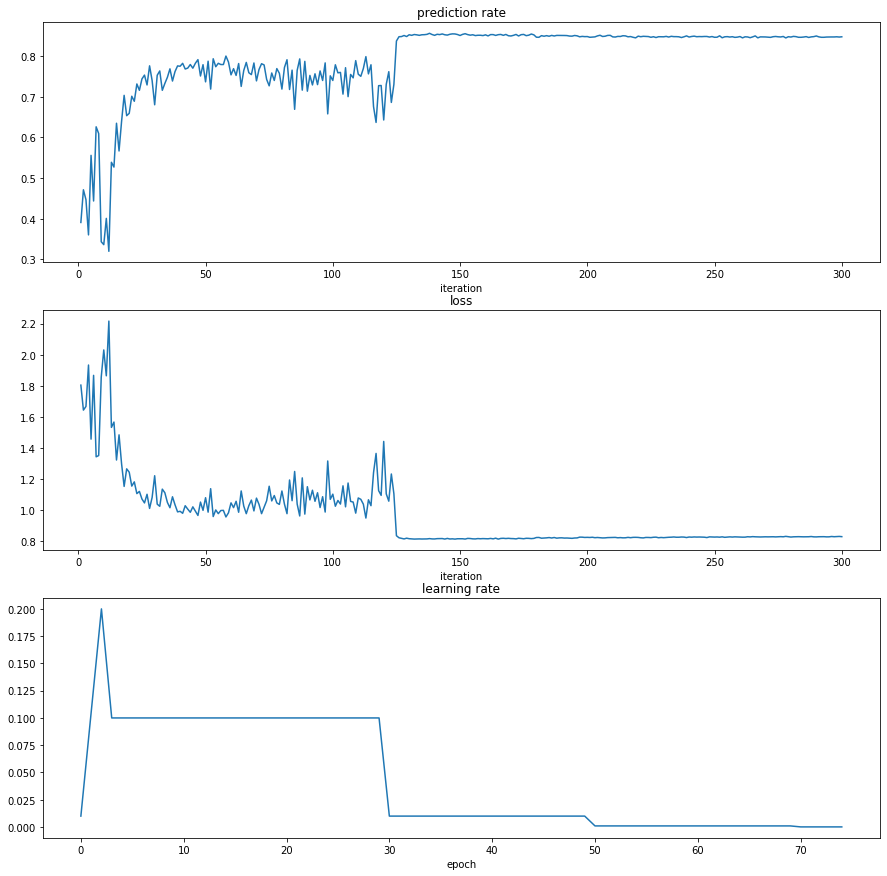

In [14]:
# draw the loss, pred_rate with iteration andd the lr with epoch
plt. figure(figsize=(15,15))

plt.subplot(311)
plt.plot(np.arange(1,len(pred_rate_ens)+1),pred_rate_ens)
plt.title('prediction rate')
plt.xlabel('iteration')

plt.subplot(312)
plt.plot(np.arange(1,len(loss_ens)+1),loss_ens)
plt.title('loss')
plt.xlabel('iteration')

plt.subplot(313)
plt.plot(np.arange(num_epochs),lr_ens)
plt.title('learning rate')
plt.xlabel('epoch')

plt.show()

In [15]:
# Save the model checkpoint，保存的是模型的参数，则保存和读取跟直接保存模型不太一样,但是这个方法成本小
# torch.save(model.state_dict(), 'resnet18_piecewise_linear.ckpt')

In [16]:
# Test the model
#model = models.resnet18().to(device)
#model.fc = nn.Linear(512, 10).to(device)  # 层都需要放到device上面

#model.load_state_dict(torch.load('resnet50_piecewise_linear.ckpt'))

model.eval()
with torch.no_grad():         # 使用 torch,no_grad()构建不需要track的上下文环境，这个时候再不会跟踪track各个tensor的梯度
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 84.32 %
